In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import numpy as np
%matplotlib inline

In [2]:
## import data
users = pd.read_csv('takehome_users.csv', encoding='latin-1') ## user data
user_eng = pd.read_csv('takehome_user_engagement.csv') ## user engagement data

In [3]:
user_eng.head(3)

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1


In [4]:
user_eng.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
time_stamp    207917 non-null object
user_id       207917 non-null int64
visited       207917 non-null int64
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


There's no null value in the user engagement table. The time_stamp column was imported as object. I'll convert it to datetime format. 

In [5]:
## convert time_stamp column to datetime
user_eng.time_stamp = pd.to_datetime(user_eng.time_stamp)

In [6]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
object_id                     12000 non-null int64
creation_time                 12000 non-null object
name                          12000 non-null object
email                         12000 non-null object
creation_source               12000 non-null object
last_session_creation_time    8823 non-null float64
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
invited_by_user_id            6417 non-null float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB


There are missing values in last_session_creation_time and invited_by_user_id. Users with missing value in last_session_creation_time are the users who have never logged into the product after registration. Users with missing value in invited_by_user_id are users that are not invited by others. 

The last_session_creation_time column is in numeric format. In order for machine learning models to read it, I will not convert it to datetime. 

##### Defining Adopted Users
In order to define adopted users, I'll use the user engagement table to find users that have logged into the product on three separate days in at least one seven day period. A new "adopted" column will be added with value 1 standing for adopted users and 0 for non-adopted users.

In [7]:
## get user adoption status
eng_count = user_eng.groupby('user_id').size()
eng_count = dict(eng_count)
adopted = {key:0 for (key, value) in eng_count.items() if value < 3}

user_ids = list(user_eng['user_id'].unique())
seven_days = seven_days = datetime.timedelta(7)

for user_id in user_ids:
    if user_id not in adopted.keys():
        user_data = user_eng[user_eng.user_id == user_id].set_index('time_stamp')
        row_n = len(user_data)
        for i in range(row_n):
            j = i
            start_time = user_data.index[i]
            end_time = start_time + seven_days
            while user_data.index[j] <= end_time:
                j += 1
                if j>=row_n:
                    adopted[user_id]= 0
                    break
            count = len(user_data[start_time:user_data.index[j-1]])
            if count >= 3:
                adopted[user_id]= 1
                break

In [8]:
# add adopted column to users table
users['adopted'] = users['object_id'].map(adopted)

# some of the users have never logged in, update those user's adoption status to 0
users_logged_in = users[users.adopted.notnull()]
users.loc[users.adopted.isnull(), 'adopted'] = 0
users.adopted = users.adopted.astype('int')

In [9]:
# percentage of adopted users

users_logged_in_adoption_pct = users_logged_in.adopted.mean()
adopted_users_pct = users.adopted.mean()
print('Percentage of adopted users among users that have logged in:', 
      '{:.2f}%'.format(users_logged_in_adoption_pct*100))
print('Percentage of adopted users among all registered users:', '{:.2f}%'.format(adopted_users_pct*100))
print('Total adopted users:', users.adopted.sum())

Percentage of adopted users among users that have logged in: 18.77%
Percentage of adopted users among all registered users: 13.80%
Total adopted users: 1656


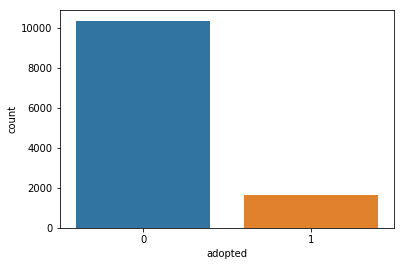

In [10]:
## adopted vs. not adopted
sns.countplot(users.adopted)
plt.show()

In [11]:
## create column to indicate if user was invited or not
users['invited'] = [1 if ~np.isnan(i) else 0 for i in users.invited_by_user_id]
users.head(3)

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted,invited
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,0,1
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,1,1
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,0,1


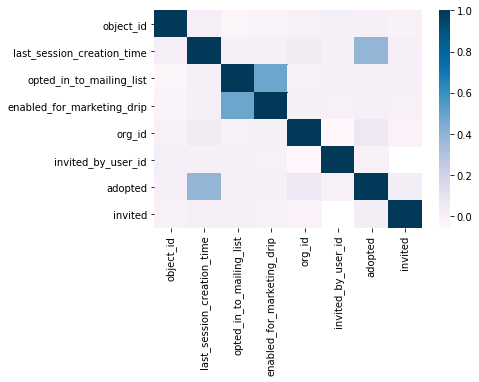

In [12]:
## correlation between variables
corr = users.corr()
sns.heatmap(corr, cmap='PuBu')
plt.show()

The above chart shows that "adopted" has a high correlation with last_session_creation_time, and opted_in_to_mailing_list and enabled_for_marketing_drip are highly correlated as well. 

##### Machine Learning Model

In [13]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

In [14]:
# One-hot-encode creation_source
users_encoded = pd.get_dummies(users, columns=['creation_source'])
users_encoded.head(3)

,object_id,creation_time,name,email,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted,invited,creation_source_GUEST_INVITE,creation_source_ORG_INVITE,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,1.398139e+09,1,0,11,10803.0,0,1,1,0,0,0,0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,1.396238e+09,0,0,1,316.0,1,1,0,1,0,0,0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,1.363735e+09,0,0,94,1525.0,0,1,0,1,0,0,0


In [15]:
# Get features and labels
X = users_encoded.drop(['object_id', 'creation_time', 'name', 'email'
                           , 'invited_by_user_id', 'adopted'], axis=1)
y = users_encoded.adopted

In [16]:
# Split train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

# Run XGBoost
model = XGBClassifier()
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [17]:
# Model Evaluation
y_pred_train = model.predict(X_train)
y_pred = model.predict(X_test)
print('Accuracy on test set: ', accuracy_score(y_train, y_pred_train))
print('Accuracy on test set: ', accuracy_score(y_test, y_pred))

Accuracy on test set:  0.9220149253731343
Accuracy on test set:  0.9207070707070707


In [18]:
# Classification Report
print(classification_report(y_test, y_pred, target_names=['Not Adopted', 'Adopted']))

              precision    recall  f1-score   support

 Not Adopted       0.94      0.96      0.95      3422
     Adopted       0.74      0.64      0.69       538

   micro avg       0.92      0.92      0.92      3960
   macro avg       0.84      0.80      0.82      3960
weighted avg       0.92      0.92      0.92      3960



In [19]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)

array([[3302,  120],
       [ 194,  344]], dtype=int64)

In [20]:
# Feature importance
feature_importance = pd.DataFrame(model.feature_importances_).T
feature_importance.columns = list(X_train.columns)
feature_importance = feature_importance.T
feature_importance.columns = ['feature_importance']
feature_importance.sort_values('feature_importance', ascending=False)

,feature_importance
last_session_creation_time,0.548689
org_id,0.301498
creation_source_GUEST_INVITE,0.037453
invited,0.035581
creation_source_PERSONAL_PROJECTS,0.026217
enabled_for_marketing_drip,0.018727
creation_source_SIGNUP_GOOGLE_AUTH,0.018727
creation_source_SIGNUP,0.009363
opted_in_to_mailing_list,0.003745
creation_source_ORG_INVITE,0.000000


##### Conclusion

The model achieved an accuracy of 92% for both the training and testing set with limited feature tuning. It predicted most of the non-adopted users correctly and captured 64% of adopted users. Among all the features, last_session_creation_time and org_id are the most predictive variables. 